In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
#mpl.use('TkAgg')

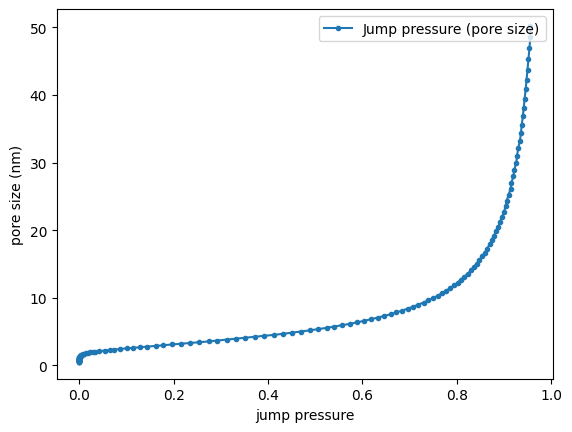

In [2]:
dataframe_sorb = pd.read_excel('Carbon-loc-isoth-N2.xlsx', header=None, sheet_name="Desorption")
P_START = 21  # индекс минимального давления
p_array = np.array(dataframe_sorb[0][P_START:])  # сетка давлений
a_array = np.array(dataframe_sorb.iloc[0][1:])  # сетка размеров пор

array_of_isotherms = np.empty((len(a_array), len(p_array)))  # массив изотерм с i-м размером пор
for i in range(len(a_array)):  # заполняем массив изотерм из таблицы pandas
    array_of_isotherms[i] = dataframe_sorb[i+1][P_START:]
    
pore_size_jump_pressure = pd.DataFrame(columns=['pore_size', 'pressure_of_jump'])  # таблица размер пор - давление при котором происходит скачок в изотерме с данным размером пор
for i, sorption_a in enumerate(array_of_isotherms):
    sorption_delta_array = sorption_a[1:] - sorption_a[:-1]
    jump_i = np.argmax(sorption_delta_array)  # индекс скачка 
    jump_pressure = p_array[jump_i]  #  давление скачка
    pore_size_jump_pressure.loc[len(pore_size_jump_pressure.index)] = [a_array[i], jump_pressure]

fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure["pressure_of_jump"], pore_size_jump_pressure["pore_size"], marker=".", label="Jump pressure (pore size)")
ax.set_ylabel("pore size (nm)")
ax.set_xlabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()

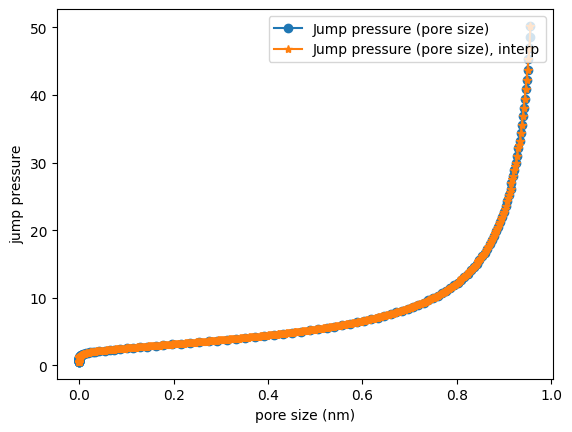

In [3]:
new_a_array = np.interp(p_array,  pore_size_jump_pressure["pressure_of_jump"].to_numpy(), pore_size_jump_pressure["pore_size"].to_numpy())  # получаем размеры пор в которых происходит скачок
# интерполяцией для кажой точки из сетки давлений
new_a_array = new_a_array[:jump_i+1]  # обрезаем массив пор так как для последних давлений не было изотерм со скачками

fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure["pressure_of_jump"], pore_size_jump_pressure["pore_size"], marker="o", label="Jump pressure (pore size)")
ax.plot(p_array[:jump_i+1], new_a_array, marker="*", label="Jump pressure (pore size), interp")
ax.set_xlabel("pore size (nm)")
ax.set_ylabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()

In [4]:
result = []
A_START = 20
a_train = a_array[A_START:]
step_array_train = pore_size_jump_pressure["pressure_of_jump"].to_numpy()[A_START:]
for step_i in range(1, len(new_a_array)-1): 
    cuurent_a_size = new_a_array[step_i]
    new_isotherms = np.zeros(shape=p_array.shape)
    j1, j2  = (np.abs(a_train - cuurent_a_size)).argsort()[:2]
    def get_k_b(x1, y1, x2, y2):
        k = (y1 - y2) / (x1 - x2)
        b = y1 - k*x1
        return k, b

    step1 = min(np.where(p_array == step_array_train[j2])[0][0], np.where(p_array == step_array_train[j1])[0][0])
    step2 = max(np.where(p_array == step_array_train[j2])[0][0], np.where(p_array == step_array_train[j1])[0][0])

    for i in range(len(p_array[:step1+1])):
        k, b = get_k_b(a_train[j1], dataframe_sorb[j1+1+A_START][P_START+i], a_train[j2], dataframe_sorb[j2+1+A_START][P_START+i])
        new_isotherms[i] = cuurent_a_size * k + b

    for i in range(len(p_array[step2+1:])):
        k, b = get_k_b(a_train[j1], dataframe_sorb[j1+1+A_START][P_START+i+step2+1], a_train[j2], dataframe_sorb[j2+1+A_START][P_START+i+step2+1])
        new_isotherms[i+step2+1] = cuurent_a_size * k + b



    for i in range(step1+1, step_i+1):
        k, b = get_k_b(p_array[i-2], new_isotherms[i-2], p_array[i-1], new_isotherms[i-1])
        new_isotherms[i] = p_array[i] * k + b

    for i in range(step2, step_i, -1):
        k, b = get_k_b(p_array[i+2], new_isotherms[i+2], p_array[i+1], new_isotherms[i+1])
        new_isotherms[i] = p_array[i] * k + b
        
    result.append(new_isotherms)

In [5]:
def get_k_b(x1, y1, x2, y2):
    k = (y1 - y2) / (x1 - x2)
    b = y1 - k*x1
    return k, b

result = []
A_START = 20
a_train = a_array[A_START:]
step_array_train = pore_size_jump_pressure["pressure_of_jump"].to_numpy()[A_START:]
for step_i in range(1, len(new_a_array)-1): 
    curent_a_size = new_a_array[step_i]
    new_isotherms = np.zeros(shape=p_array.shape)
    j1, j2  = (np.abs(a_train - curent_a_size)).argsort()[:2]  # находим индексы ближайших к текущему размеров пор
    step1 = min(np.where(p_array == step_array_train[j2])[0][0], np.where(p_array == step_array_train[j1])[0][0])
    # находим индекс давления до ступеньки
    step2 = max(np.where(p_array == step_array_train[j2])[0][0], np.where(p_array == step_array_train[j1])[0][0]) 
    # находим индекс давления после ступеньки

    #считаем новую изотерму через аппроксимация и интерполяция
    for i in range(len(p_array[:step1+1])):
        k, b = get_k_b(a_train[j1], dataframe_sorb[j1+1+A_START][P_START+i], a_train[j2], dataframe_sorb[j2+1+A_START][P_START+i])
        new_isotherms[i] = curent_a_size * k + b

    for i in range(len(p_array[step2+1:])):
        k, b = get_k_b(a_train[j1], dataframe_sorb[j1+1+A_START][P_START+i+step2+1], a_train[j2], dataframe_sorb[j2+1+A_START][P_START+i+step2+1])
        new_isotherms[i+step2+1] = curent_a_size * k + b

    for i in range(step1+1, step_i+1):
        k, b = get_k_b(p_array[i-2], new_isotherms[i-2], p_array[i-1], new_isotherms[i-1])
        new_isotherms[i] = p_array[i] * k + b

    for i in range(step2, step_i, -1):
        k, b = get_k_b(p_array[i+2], new_isotherms[i+2], p_array[i+1], new_isotherms[i+1])
        new_isotherms[i] = p_array[i] * k + b
        
    result.append(new_isotherms)

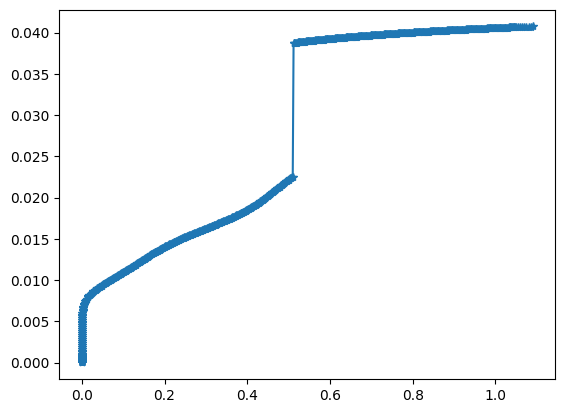

In [16]:
plt.plot(p_array, result[300], marker = "*")
#plt.plot(p_array[step1-10:step2+10], array_of_isotherms[j1 + A_START][step1-10:step2+10], marker = "*")
#plt.plot(p_array[step1-10:step2+10], array_of_isotherms[j2 + A_START][step1-10:step2+10], marker = "*")
plt.show()

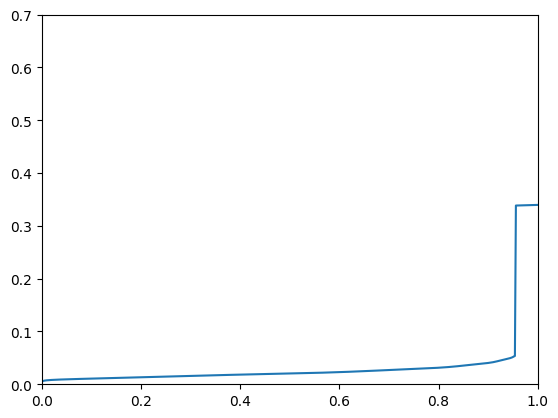

In [28]:
# анимация всех новых изотерм
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig, ax = plt.subplots()
line2 = ax.plot(p_array, result[0])[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.7)
def update(frame):
    # update the line plot:
    line2.set_ydata(result[frame])
    return (line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=len(result), interval=30)
writervideo = animation.FFMpegWriter(fps=60)
ani.save('test.mp4', writer=writervideo)

plt.show()

In [30]:
# сохраняем изотермы и размеры пор в формате np
now = datetime.now().strftime('%Y-%m-%d_T_%H-%M-%S')
with open(f'data/kernel_generated/kernel_isotherms_Carbon{now}.npy', 'wb') as f:
    np.save(f, np.array(result))

with open(f'data/kernel_generated/kernel_a_array_Carbon{now}.npy', 'wb') as f:
    np.save(f, new_a_array)